# Classification of Pulsar Stars From the HTRU2 Data Set

In [1]:
set.seed(1)
library(tidyverse) 
library(repr) 
library(tidymodels) 
library(ggplot2)
library(GGally)
library(cowplot)
library(caret)
library(yardstick)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## 1) Introduction

In this report, we will be creating a classifier using the HTRU2(High Time Resolution Universe) dataset to figure out if a set of signals is coming from a pulsar star or not. The HTRU2 dataset classifies radio signal profiles as those from pulsar stars or from non-pulsars/noise. Pulsars are a type of rare neutron star that are extremely dense and spins rapidly while emitting lots of light and radiation [1]. Pulsars are formed when a massive star which is 8-25 times the mass of the Sun explodes in a supernova event and essentially leaves us with the inner part of the star crumbled together due to the force of gravity [2] The pulsars are detected through periodic radio signals that we measure from Earth and that have slightly different emission patterns depending on rotation [3]. However, sometimes detections of periodic radio signals are a result of RFI (radio frequency interference) and noise and thus are not actual pulsars, which can make it more challenging to recognize a pulsar. To build our classifier, we have decided to use the following variables as predictors: 

- mean of the integrated profile
- excess kurtosis of the integrated profile
- excess kurtosis of the DM-SNR curve
- standard deviation of the DM-SNR curve

You will see how we chose our variables using a scatterplot and boxplot matrix in the methods section below. Integrated profile refers to the averaged emission of periodic radio signals taking into account time and frequency over many rotations, since pulsar stars rotate [4]. Kurtosis refers to the tailedness of a distribution and whether it is light-tailed or heavy-tailed when compared to the normal distribution [5]. Typically high kurtosis means more heavier tails and thus more outliers, whereas low kurtosis means the data has lighter tails and thus less outliers. Mean refers to average and standard deviation refers to the varation in a data set.  

DM in DM-SNR refers to the Dispersion Measure, which essentially represents the number of free electorns between us and the pulsar per unit area [6]. SNR in DM-SNR refers to the Signal to Noise Ratio which "compares the level of a desired signal to the level of background noise" [7]. 

This dataset will use binary classification where "1" represents a pulsar, and "0" represents a non-pulsar/noise.

Our project then aims to answer the question: **Can we use the mean and excess kurtosis of the integrated profile and the excess kurtosis and standard deviations of the DM-SNR curves of signal profiles to predict whether a signal (of unknown class) is the result of a pulsar or non-pulsar?**

We will be building a classifier using the K-Nearest Neighbors (K-NN) classification algorithm. This algorithm simply speaking, 
is a machine learning method that is used for classification tasks by training the model on labeled data to make predictions on unseen data. We want to see if we can predict a categorical class based on variables/features. The core of K-NN is that if two data points have similar features, they are likely to belong to the same class, so in our case, either pulsar (1) or non-pulsar (0). The value of K stands for the number of neighbors we are going to identify which have the closest distance to the new data point that needs to be classified. We see what is the majority class of the K neighboring points and assign this class to the new point. 

*Link to our dataset: https://archive.ics.uci.edu/ml/datasets/HTRU2#*

## 2) Methods and Results

We will first read in the data from the web source, and display the data in a dataframe with the variables displayed.  

In [17]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "data/pulsardata.zip") 
unzip("data/pulsardata.zip") 
pulsar_data <- read_csv("HTRU_2.csv", col_names = FALSE) |>
    mutate(X9 = as_factor(X9)) 

colnames(pulsar_data) <- make.names(c("Mean of the integrated profile" , "Standard deviation of the integrated profile",
                           "Excess kurtosis of the integrated profile", "Skewness of the integrated profile", 
                           "Mean of the DM-SNR curve", "Standard deviation of the DM-SNR curve", 
                           "Excess kurtosis of the DM-SNR curve", "Skewness of the DM-SNR curve", "Class"))


pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean.of.the.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


Before we dive into building our classfier, we want to demonstrate how we determined which variables to use. We generated a scatterbox matrix accompanied by box plots to the side and distribution plots at the bottom. We looked for variables that had significant differences between the two classes. We determined that the mean of the integrated profile, excess kurtosis of the integrated profile, excess kurtosis of the DM-SNR curve and the standard deviation ofthe  DM-SNR curve were good variables to use because these variable profiles exihibited signiciant differences between the two classes. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



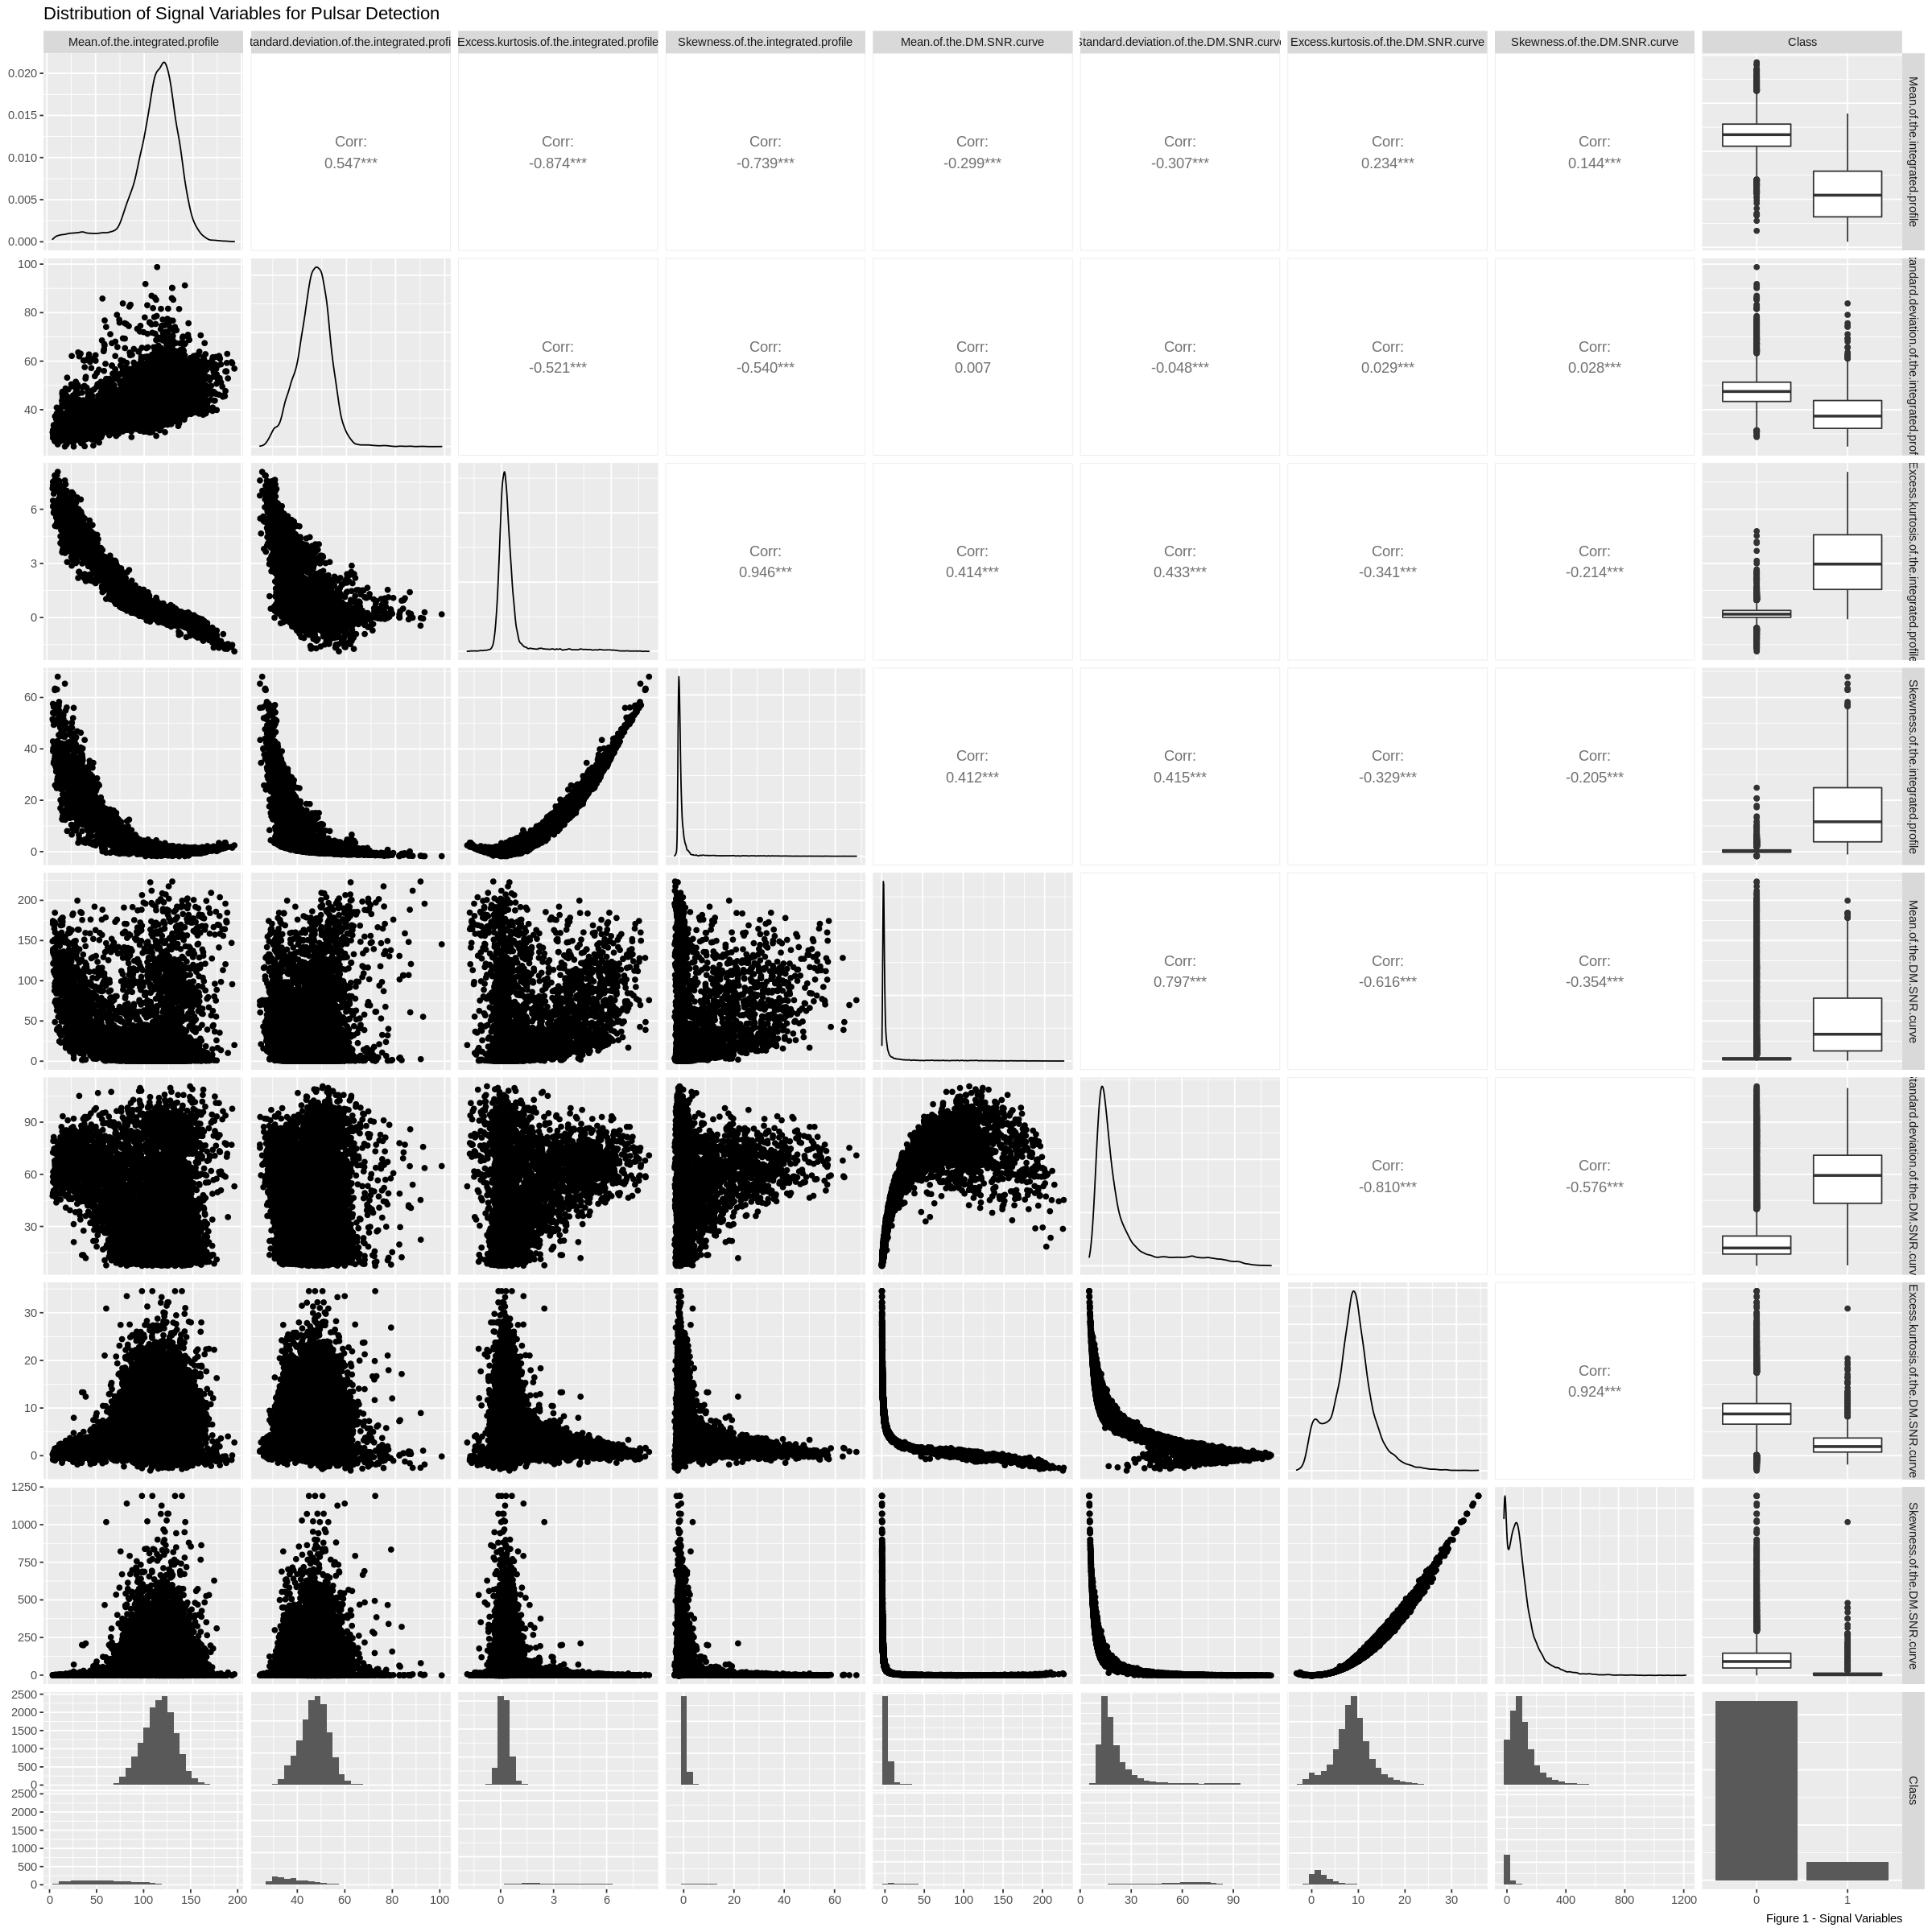

In [26]:
options(repr.plot.width = 20, repr.plot.height = 20)

pulsar_matrix <-ggpairs(pulsar_data) +
                ggtitle("Distribution of Signal Variables for Pulsar Detection") +
                labs(caption = "Figure 1 - Signal Variables") 
    
pulsar_matrix

Now, we will begin cleaning and wrangling our data to make it easier to summarize. We will select for the variables we are interested for and also drop any rows that have missing values in the data frame.  

In [27]:
pulsar_data  <- pulsar_data |>
            select(Mean.of.the.integrated.profile, Excess.kurtosis.of.the.integrated.profile, Excess.kurtosis.of.the.DM.SNR.curve, Standard.deviation.of.the.DM.SNR.curve, Class) |>
            drop_na()

pulsar_data

Mean.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Excess.kurtosis.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,-0.234571412,7.975532,19.110426,0
102.50781,0.465318154,10.576487,14.860146,0
103.01562,0.323328365,7.735822,21.744669,0
136.75000,-0.068414638,6.896499,20.959280,0
88.72656,0.600866079,14.269573,11.468720,0
93.57031,0.531904850,10.621748,14.545074,0
119.48438,0.031460220,19.206230,9.279612,0
130.38281,-0.158322759,13.539456,14.378941,0
107.25000,0.452688025,9.001004,14.486853,0


Since we are building a classifier, we must split our data into training and testing data. The training data will be used to build our classifer and the testing data will be used once we have built the classifier in order to test it. We can also see how many observations are in our training data. Remember "0" means non-pulsar whereas "1" means it is a pulsar. 

In [28]:
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = Class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

pulsar_summary <- pulsar_train  |>
    group_by(Class) |>
    summarise(count = n())

pulsar_summary


Class,count
<fct>,<int>
0,12189
1,1234


Now let us compare the distribution of our variables in the training data through a scatterplot. 

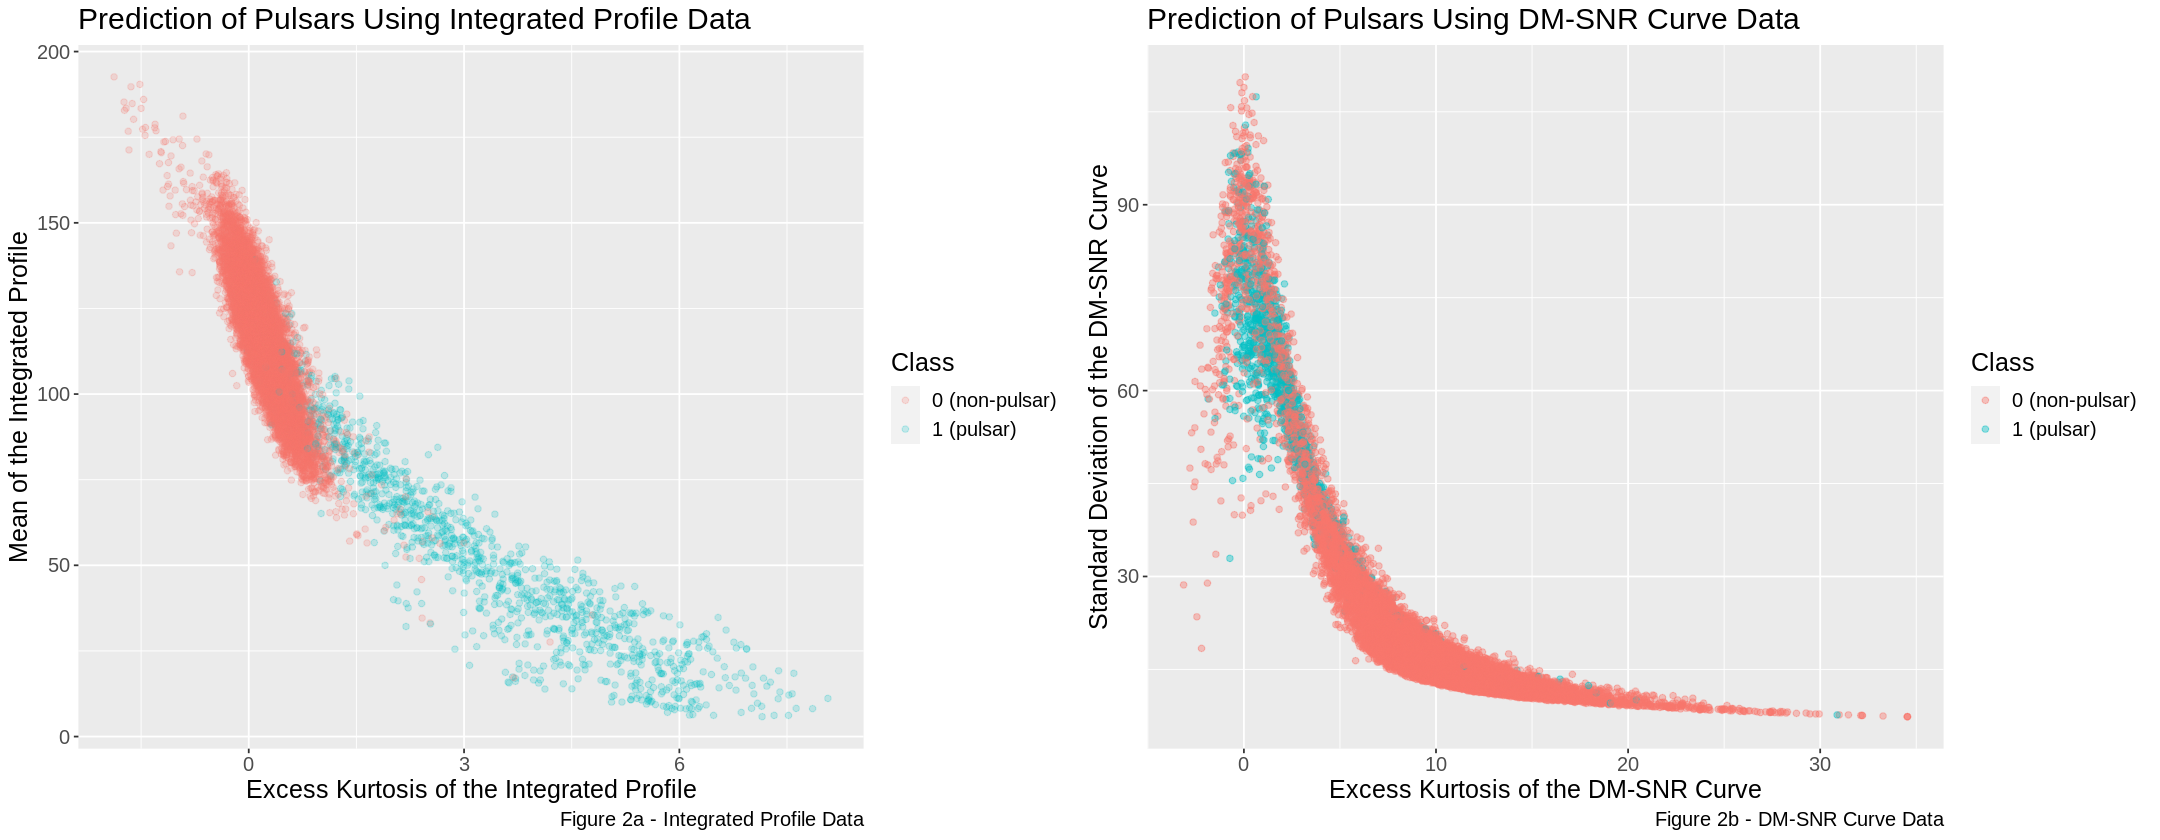

In [29]:
options(repr.plot.width = 18, repr.plot.height = 7)

integrated_plot <- pulsar_train |>
            ggplot(aes(x = Excess.kurtosis.of.the.integrated.profile, y= Mean.of.the.integrated.profile, color = Class)) +
            geom_point(alpha = 0.2) +
            xlab("Excess Kurtosis of the Integrated Profile") + 
            ylab("Mean of the Integrated Profile") +
            scale_color_discrete(labels = c("0 (non-pulsar)", "1 (pulsar)")) +
            ggtitle("Prediction of Pulsars Using Integrated Profile Data") + 
            labs(caption = "Figure 2a - Integrated Profile Data") +
            theme(text = element_text(size = 15))

curve_plot <- pulsar_train |>
            ggplot(aes(x = Excess.kurtosis.of.the.DM.SNR.curve, y= Standard.deviation.of.the.DM.SNR.curve, color = Class)) +
            geom_point(alpha = 0.4) +
            xlab("Excess Kurtosis of the DM-SNR Curve") + 
            ylab("Standard Deviation of the DM-SNR Curve") +
            scale_color_discrete(labels = c("0 (non-pulsar)", "1 (pulsar)")) +
            ggtitle("Prediction of Pulsars Using DM-SNR Curve Data") +
            labs(caption = "Figure 2b - DM-SNR Curve Data") +
            theme(text = element_text(size = 15))


plot_grid(integrated_plot, curve_plot, nrow = 1)    

Since K-NN is sentive to the scale of predictors, we should also do some preprocessing to standarize the data. We are going to create a recipe that first selects the four variables we want to use as predictors in order for us to then scale and center the data from these variables

In [34]:
pulsar_recipe <- recipe(Class ~.,data = pulsar_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

pulsar_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we will actually create and specify the K-NN model. However, it could be really hard to find the optimal value of K that comes up with the most precise classifications, so we have to tune our model using the training data to find the best K. 

In [36]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Then, to experiment with some possible Ks to pick the best one, we make use of a method called 5-fold cross-validation. The idea of 5-fold cross-validation is we split the overall training data into 5 evenly-sized chunks or folds, and then iteratively use 1 chunk as validation set and the remaining chunks as training sets. We train our model on the training set and test on the validation set and whichever k value yields the highest cross-validation accuracy is the one we use. We can get a sence of how our model works without touching the actual test data. 

In [42]:
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = Class)

Finally, we create a workflow that combines the model specification, recipe, and cross-validation together. We then execute the workflow and collect the performance metric of each model with a specific parameter. Remember we are tunning the model with different K, so we also have to specify how many K's we would like to experiment with, and here we are using 20 K values in our tuning. 

In [43]:
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

pulsar_result <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
    collect_metrics()

pulsar_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9664753,5,0.0019680720,Preprocessor1_Model01
1,roc_auc,binary,0.9013724,5,0.0046433567,Preprocessor1_Model01
2,accuracy,binary,0.9664753,5,0.0019680720,Preprocessor1_Model02
2,roc_auc,binary,0.9301305,5,0.0048129098,Preprocessor1_Model02
3,accuracy,binary,0.9778736,5,0.0010185247,Preprocessor1_Model03
3,roc_auc,binary,0.9398407,5,0.0042641015,Preprocessor1_Model03
4,accuracy,binary,0.9778736,5,0.0010185247,Preprocessor1_Model04
4,roc_auc,binary,0.9452929,5,0.0044927325,Preprocessor1_Model04
5,accuracy,binary,0.9798852,5,0.0003732620,Preprocessor1_Model05


Now let's decide which K value is the best by plotting the K values and its accuracies displayed in a line graph.

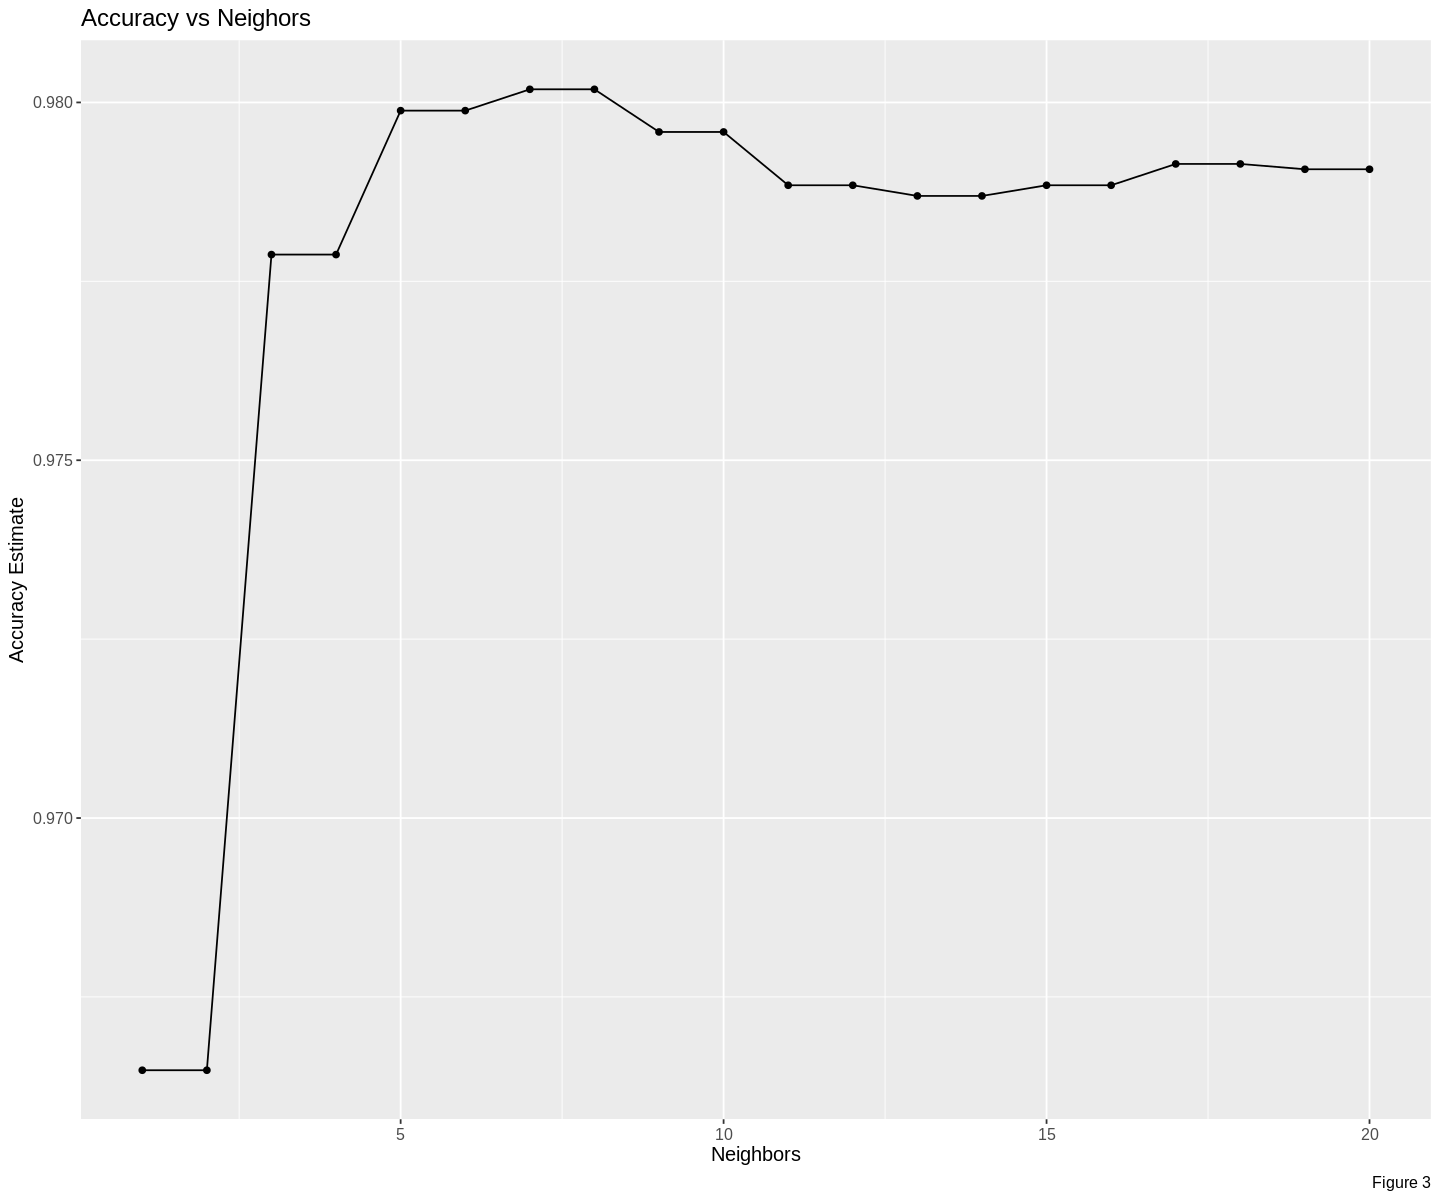

In [45]:
options(repr.plot.width = 12, repr.plot.height = 10)

accuracies <- pulsar_result |> 
       filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs Neighors", caption = "Figure 3") + 
  theme(text = element_text(size = 12)) 

accuracy_vs_k

In the graph, we can clearly see that the accuracy is highest when K = 7 or 8, but we will choose K = 7 since it is better to have an odd K to avoid ties. 

Now let us use K = 7 to create the KNN model and to execute the workflow. 

In [46]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
              set_engine("kknn") |>
              set_mode("classification")

best_fit <- workflow() |>
             add_recipe(pulsar_recipe) |>
             add_model(best_spec) |>
             fit(data = pulsar_train)

Now, let us use our final model and examine the accuracy of it by predicting on the test data. We will also report the accuracy of the model and the confusion matrix. 

In [62]:
pulsar_predictions <- predict(best_fit, pulsar_test) |>
                        bind_cols(pulsar_test)

pulsar_metrics <- pulsar_predictions |> 
                  metrics(truth = Class, estimate = .pred_class) |>
                  filter(.metric == "accuracy")

pulsar_conf_mat <- pulsar_predictions |>
                        conf_mat(truth = Class, estimate = .pred_class) 
pulsar_metrics
pulsar_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9776536


          Truth
Prediction    0    1
         0 4040   70
         1   30  335

We have also created a visualization of our confusion matrix below. 

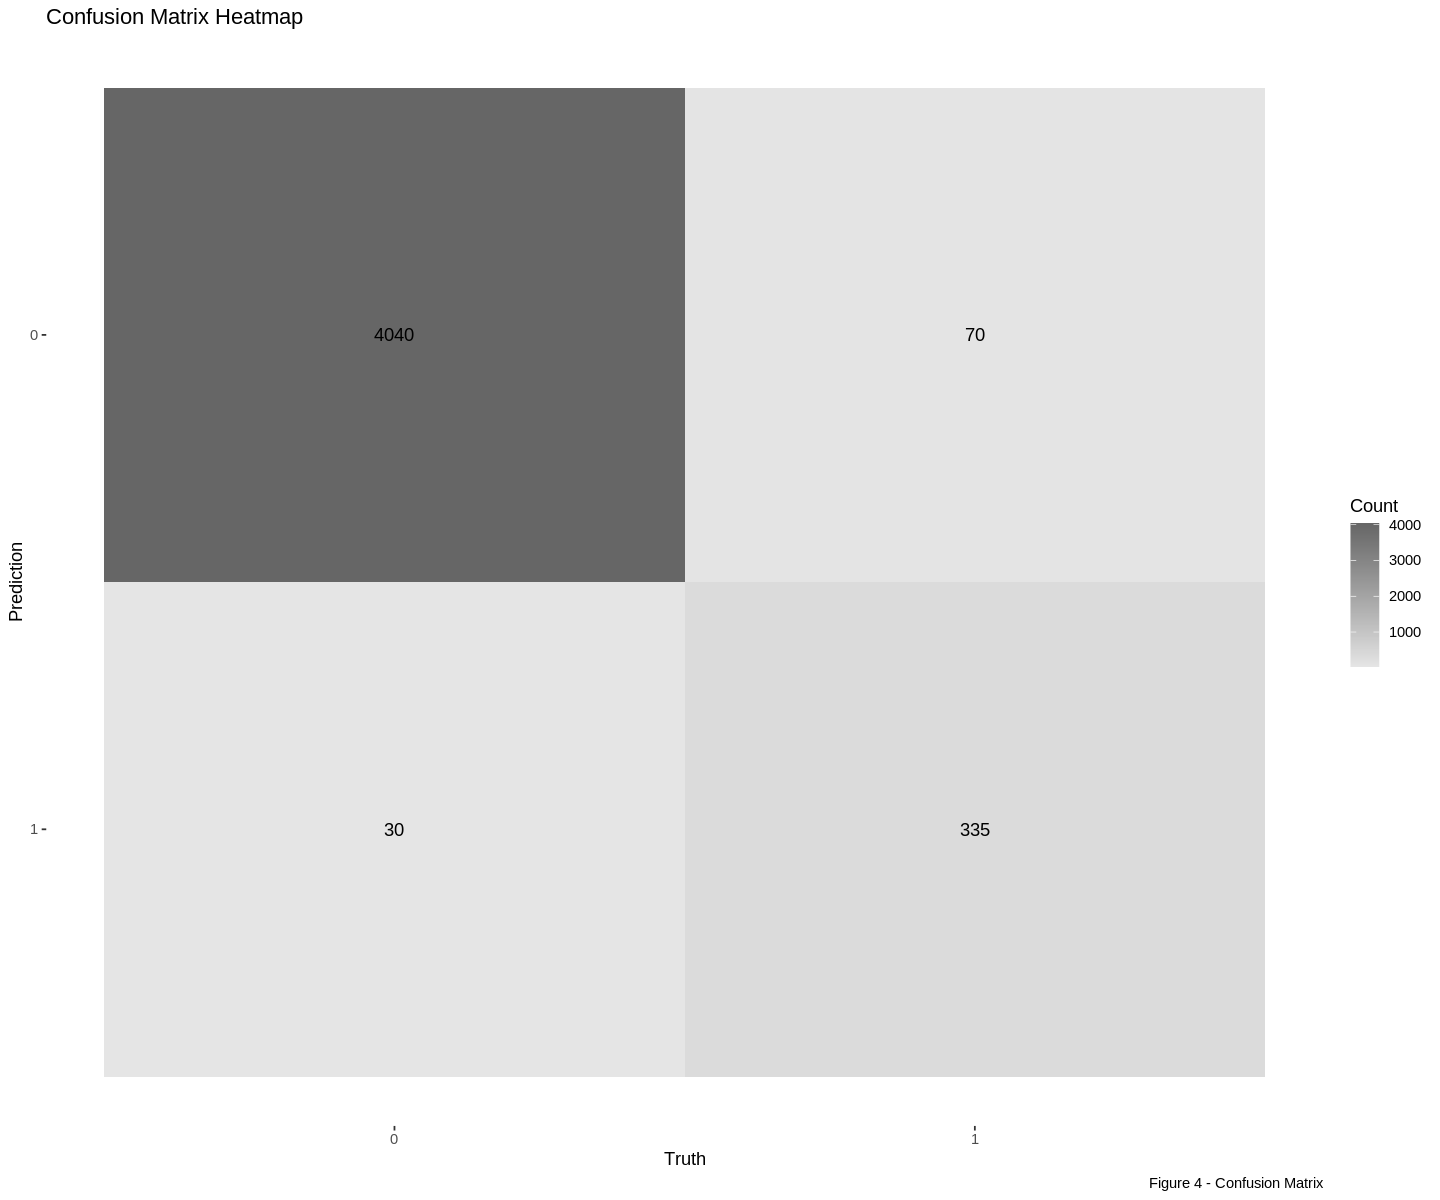

In [60]:
matrix_visual <- autoplot(pulsar_conf_mat, type = "heatmap") +
        theme(legend.position = "right") +
        labs(fill="Count") +
        ggtitle("Confusion Matrix Heatmap") +
        labs(caption = "Figure 4 - Confusion Matrix")

matrix_visual

## 3) Discussion

When we look at the metrics computed above, we can see that we have an accuracy of 0.98 or 98%, which means that our classifier did a good job for the most part at detecting whether a set of signals came from a pulsar(1) or non-pulsar (0). Through the summary of observations earlier and through the confusion matrix, we can also see that majority of the predictions are 0 (non-pulsars). This is what we expected to find, as pulsar stars are a type of neutron star and neutron stars are quite rare in general [8]. 

Pulsar stars can be valuable tools to help predict other space and physics phenomena since it is widley known that they are very dense and emit a lot of radiation. By building a classifer that helps identify pular stars faster, it may help to speed up scientific research and discovery within astronomy. For example, pulsar stars can carry information about other things like space-time and gravitational waves caused by motions of things like blackholes[9]. By understanding pulsars, we may be able to answer to what extent can pulsars be predictve and provide information of other space and astrophysics phenomena. 

Furthermore, by finding where pulsar stars are located, this can help us find where pulsar planets are located and the frequency of these planets. Pulsar planets are rare and are planets that rotate around pulsars [10].  One future question may raise up is to what extent the pulsars we identify could help us verify our current theories of physics and the universe, as pulsars are already being used to look at Einstein's Theory of General Relativity for example [11].  

## 4) References (IEEE Format)

[1] R. Lea, “What are pulsars?,” Space.com, 22-Apr-2016. [Online]. Available: https://www.space.com/32661-pulsars.html.

[2] R. Mandow, “Science talk - what are pulsar planets?,” Spaceaustralia, 05-Aug-2022. [Online]. Available: https://spaceaustralia.com/news/science-talk-what-are-pulsar-planets. 

[3] D. R. Lorimer and M. Kramer, 'Handbook of Pulsar Astronomy', Cambridge University Press, 2005.

[4] R. J. Lyon, 'Why Are Pulsars Hard To Find?', PhD Thesis, University of Manchester, 2016.

[5] 1.3.5.11. Measures of Skewness and Kurtosis,” national institutes of standards and technology. [Online]. Available: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm#:~:text=Kurtosis%20is%20a%20measure%20of,tails%2C%20or%20lack%20of%20outliers. 

[6] “Pulsar dispersion measure: Cosmos,” Pulsar Dispersion Measure | COSMOS. [Online]. Available: https://astronomy.swin.edu.au/cosmos/p/pulsar+dispersion+measure. 

[7] W. Gragido, J. Pirc, N. Selby, and D. Molina, “Signal-to-noise ratio,” Blackhatonomics, pp. 45–55, 2013.

[8] “Black holes and Neutron Stars,” University of Maryland: Department of Astronomy. [Online]. Available: https://www.astro.umd.edu/~miller/poster1.html#:~:text=Neutron%20stars%20are%20born%20during,least%2040%20light%20years%20away.

[9] N. Nm, “Pulsars: The Universe's gift to physics,” Astronomy.com, 20-Feb-2012. [Online]. Available: https://astronomy.com/news/2012/02/pulsars---the-universes-gift-to-physics. 

[10] B. Berman, “Weird object: Pulsar planets,” Astronomy.com, 23-Oct-2015. [Online]. Available: https://astronomy.com/magazine/weirdest-objects/2015/10/10-pulsar-planets. 

[11] “Black holes and Neutron Stars,” University of Maryland: Department of Astronomy. [Online]. Available: https://www.astro.umd.edu/~miller/poster1.html#:~:text=Neutron%20stars%20are%20born%20during,least%2040%20light%20years%20away. 